In [12]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpy as np 
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

## Preparing the data for the neural network

In [13]:
# Extract and prepare data

# Windows directory

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 5 Outputs (removed massfin, G_GAIA, and MeH)
teff = []
luminosity = []
dnufit = []
FeH = []
numax = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:
    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process (or not)
    selected_tracks = track_names[:]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs (removed massfin, G_GAIA, and MeH)
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        numax.append(track['numax'][:])

# Convert lists to numpy arrays and concatenate 
# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, yini]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                             np.concatenate(alphafe).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, numax]  # Removed massfin

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH (removed MeH and G_GAIA)
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])

## Converting to tensors to train

In [14]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

## Neural network 

In [15]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),  # 2
            nn.ReLU(),
            nn.Linear(256, 256),  # 3
            nn.ReLU(),
            nn.Linear(256, 256),  # 4
            nn.ReLU(),
            nn.Linear(256, 256),  # 5
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
ckpt_path = "best_model_v8-1-epoch=9965-val_loss=0.0071.ckpt"
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

## Training neural network

In [16]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

## Extracting data for specific track

In [ ]:
import jax.numpy as jnp

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track: 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    age_07294 = specific_track['age'][:].reshape(-1, 1)
    massini_07294 = specific_track['massini'][:].reshape(-1, 1)
    fehini_07294 = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt_07294 = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini_07294 = specific_track['yini'][:].reshape(-1, 1)
    eta_07294 = specific_track['eta'][:].reshape(-1, 1)
    alphafe_07294 = specific_track['alphaFe'][:].reshape(-1, 1)

    # Retrieve actual values for plotting
    teff_07294 = specific_track['Teff'][:]
    luminosity_07294 = specific_track['LPhot'][:]
    dnufit_07294 = specific_track['dnufit'][:]
    FeH_07294 = specific_track['FeH'][:]
    numax_07294 = specific_track['numax'][:]



## Emulate function for Bayesian model

In [6]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x

In [7]:
obs = {
    'teff': teff_07294,
    'lum': luminosity_07294,
    'dnu': dnufit_07294,
    'feh': FeH_07294,
    'numax': numax_07294,
}

## Bayesian model

In [8]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.sample("ages_s", dist.Uniform(2500, 10000))  
    massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 0.7)
    fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2.0)
    alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
    yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
    eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
    alphafe_ = numpyro.deterministic("alphafe_", 0.8 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.2)

    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.hstack(log_transformed_inputs + [fehini_, alphafe_])

    # Scale x manually
    mean_x = scaler_X.mean_
    scale_x = scaler_X.scale_  
    x_scaled = (x - mean_x) / scale_x

    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled)
    
    # De-scale y manually 
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y
    
    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0]))
    lum = numpyro.deterministic("lum", jnp.power(10.0, y[..., 1]))
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3]))
    feh = numpyro.deterministic("feh", y[..., 4])

    
    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, 5), obs=teff_07294)
        numpyro.sample("lum_obs", dist.StudentT(5, lum, 1), obs=luminosity_07294)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, 0.8), obs=dnufit_07294)
        numpyro.sample("feh_obs", dist.StudentT(5, feh, 0.1), obs=FeH_07294)
        numpyro.sample("numax_obs", dist.StudentT(5, numax, 0.02), obs=numax_07294) 

## Prior predictive

In [17]:
from jax import random

nuts_kernel = NUTS(Bmodel)

prior_mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
prior_mcmc.run(rng_key)

posterior_samples = prior_mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:05<00:00, 698.78it/s, 7 steps of size 5.71e-01. acc. prob=0.92]  


c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Dell\miniconda3\Lib\site-packages\arviz\stats\density_utils.py:707: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Dell\miniconda3\Lib\site-packages\arviz\stats\density_utils.py:707: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) /

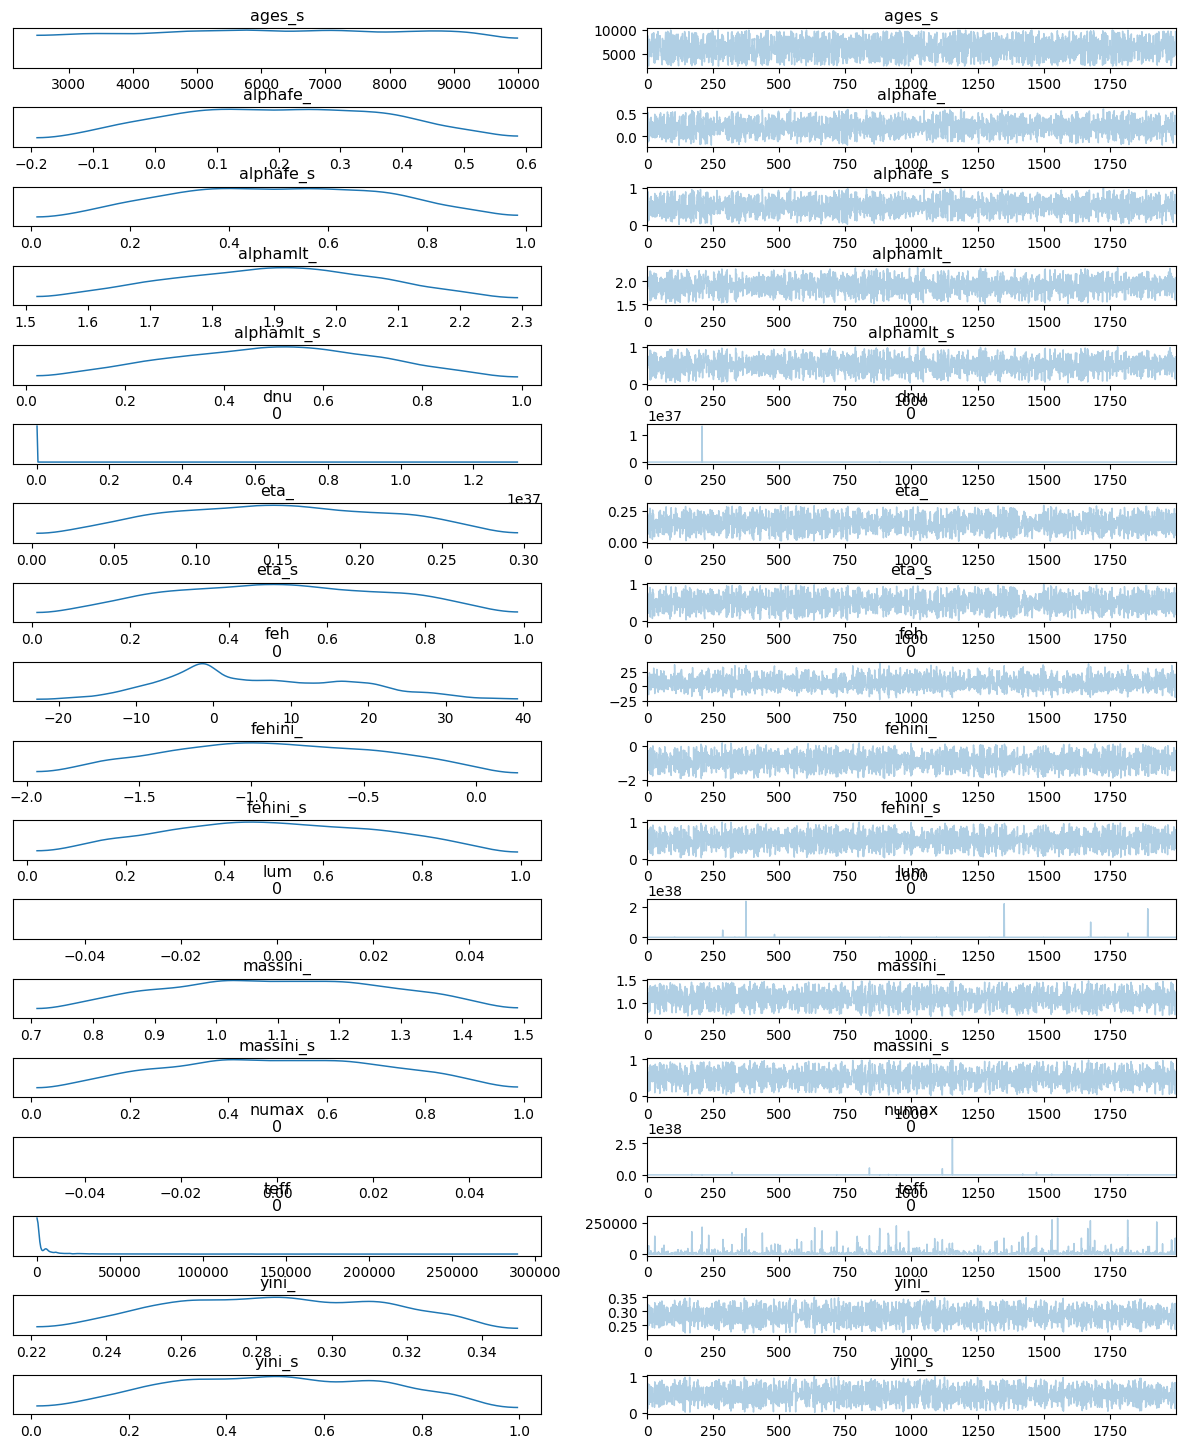

In [226]:
import arviz as az

prior_trace = az.from_numpyro(prior_mcmc)
az.plot_trace(prior_trace, compact=False, figsize=(15, 18));  

plt.subplots_adjust(hspace=1)  

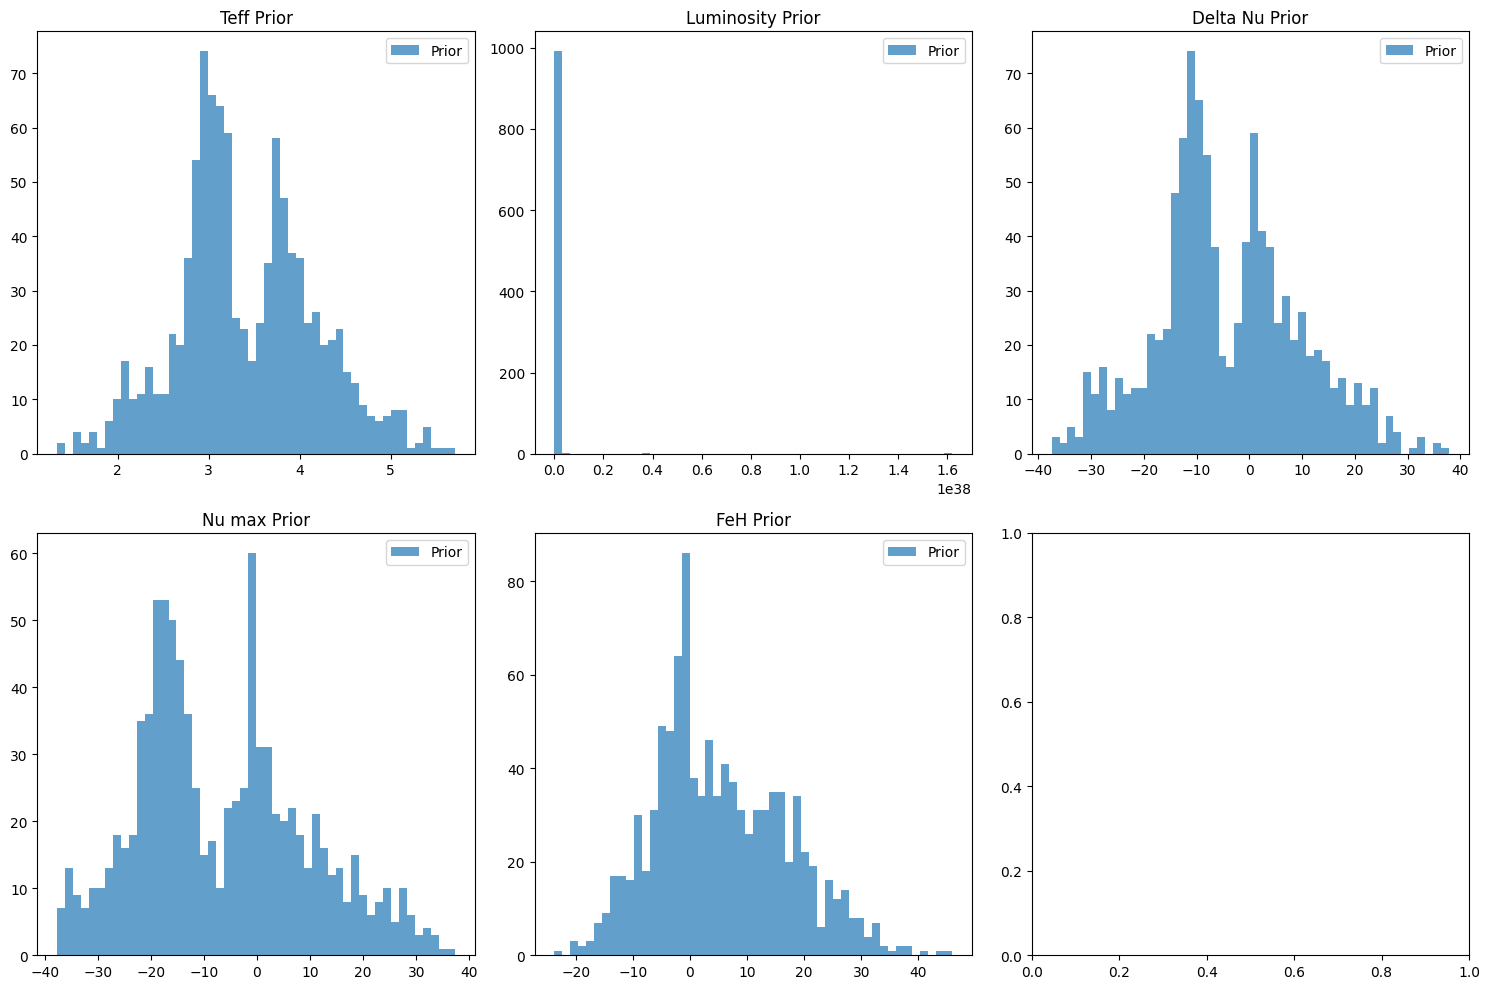

In [ ]:
# Run observables predictive
prior_predictive = numpyro.infer.Predictive(Bmodel, num_samples=1000)
prior_samples = prior_predictive(rng_key=random.PRNGKey(0), obs=1)

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Function to remove infinite and nan values and plot histogram
def hist(ax, data, title, observed=None, bins=50):
    # Remove inf and nan values
    data = data[~jnp.isinf(data)]
    data = data[~jnp.isnan(data)]
    
    if data.size > 0:
        ax.hist(data, bins=bins, alpha=0.7, label='Prior')
        
        if observed is not None:
            observed = observed[~jnp.isinf(observed)]
            observed = observed[~jnp.isnan(observed)]
        
        ax.set_title(title)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center')

# Plot histograms
hist(axes[0], jnp.log10(prior_samples['teff']), 'Teff Prior', teff_07294)
hist(axes[1], jnp.log10(prior_samples['lum']), 'Luminosity Prior', luminosity_07294)
hist(axes[2], jnp.log10(prior_samples['dnu']), 'Delta Nu Prior', dnufit_07294)
hist(axes[3], jnp.log10(prior_samples['numax']), 'Nu max Prior', numax_07294)
hist(axes[4], prior_samples['feh'], 'FeH Prior', FeH_07294)

plt.tight_layout()
plt.show()

## Running model and Posterior plotting 

In [9]:
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=2)
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_49524\1203883282.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=2)


AttributeError: module 'random' has no attribute 'PRNGKey'

In [ ]:
trace = az.from_numpyro(mcmc)

az.summary(trace)

In [ ]:
az.plot_trace(trace);

In [ ]:
# Setting truth values for corner plot
truth_values = [ages[0].item(), massini[0].item(), alphamlt[0].item(), eta[0].item(), yini[0].item(),  fehini[0].item(), alphafe[0].item()]
print(truth_values)
import corner

corner.corner(trace, var_names=['ages_s', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truth_values);

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# Extract the variables from the trace
ages_samples = trace.posterior['ages_s'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()



# sample 910 values from the model:

# Length of the ages_samples
n_samples = len(ages_samples)

# Indices of the minimum and maximum values
min_idx = np.argmin(ages_samples)
max_idx = np.argmax(ages_samples)

# If ages_samples is long enough, divide the remaining range into even intervals
# Calculate the total number of intervals (excluding the min and max)
num_intervals = 910 - 2  # Subtract 2 because min and max are already selected

# Calculate step size for evenly spaced sampling
step = (n_samples - 1) // num_intervals  # This will give us roughly equal intervals

# Generate the indices for evenly spaced sampling, including min and max
evenly_spaced_indices = [min_idx, max_idx]  # Start with min and max indices
for i in range(1, num_intervals + 1):
    idx = i * step
    evenly_spaced_indices.append(idx)

# Sort the indices to ensure they're in ascending order
ages_indices = np.sort(evenly_spaced_indices)

# Subsample all variables
ages_subsample = np.sort(ages_samples[ages_indices]).reshape(-1, 1)
mass_subsample = np.full(910, np.mean(mass_samples)).reshape(-1, 1)
mlt_subsample = np.full(910, np.mean(mlt_samples)).reshape(-1, 1)
eta_subsample = np.full(910, np.mean(eta_samples)).reshape(-1, 1)
yini_subsample = np.full(910, np.mean(yini_samples)).reshape(-1, 1)
fehini_subsample = np.full(910, np.mean(fehini_samples)).reshape(-1, 1)
fe_subsample = np.full(910, np.mean(fe_samples)).reshape(-1, 1)

epsilon = 1e-10
log10_hbm_inputs = [ages_subsample, mass_subsample, mlt_subsample, eta_subsample, yini_subsample] 
log10_transformed_hbm_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_hbm_inputs]


# Combine log-transformed inputs with raw `fehini` and `yini`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, fe_subsample])

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)

In [ ]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()